## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import nltk
import re
from collections import Counter

## 4. Vectorization

### 4.0 Import Data

In [2]:
enron_emails = pd.read_csv('../data/enron_emails_processed1.csv')

In [3]:
trec_emails = pd.read_csv("../data/trec_emails_processed.csv")

### 4.1 Combine both datasets

In [4]:
enron_vec = enron_emails[['clean_msg_no_lst', 'target']].copy()
print(enron_vec.shape)

(33345, 2)


In [5]:
trec_vec = trec_emails[['clean_msg_no_lst', 'target']].copy()
print(trec_vec.shape)

(60519, 2)


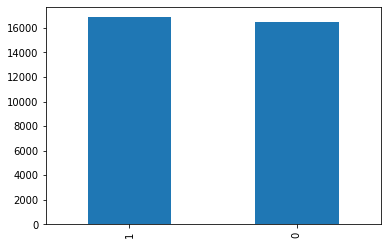

In [6]:
enron_vec['target'].value_counts().plot(kind = 'bar');

In [7]:
enron_vec = enron_vec.drop(enron_vec.query('target == 1').sample(random_state = 99, frac = .40).index)

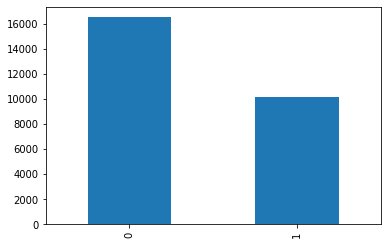

In [8]:
enron_vec['target'].value_counts().plot(kind = 'bar');

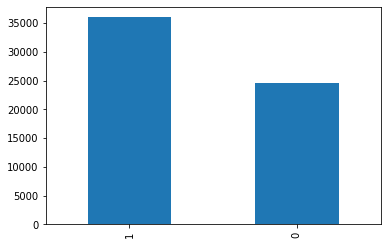

In [9]:
trec_vec['target'].value_counts().plot(kind = 'bar');

In [10]:
trec_vec = trec_vec.drop(trec_vec.query('target == 1').sample(random_state = 99, frac = .20).index)

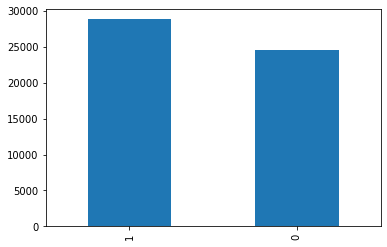

In [11]:
trec_vec['target'].value_counts().plot(kind = 'bar');

In [12]:
data = pd.concat([enron_vec, trec_vec], ignore_index = True)

### 4.2 Create a Bigram Count Vectors for the Entire Corpus

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

#### Use Tfidfvectorizer to Compute word counts, idf and tf-idf values

In [14]:
tfidf_vectorizer = TfidfVectorizer(ngram_range = (2, 2), min_df = 10, use_idf = True)
tfidf_vectorizer.fit(data['clean_msg_no_lst'].astype('U'))

TfidfVectorizer(min_df=10, ngram_range=(2, 2))

### 4.3 Train-Test-Split: Enron Data as Train Set & Subset of TREC2007 as Test Set

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
a, X_test, b, Y_test = train_test_split(trec_vec[['clean_msg_no_lst']], trec_vec.target, random_state = 99, test_size = 0.15)

print(f"a shape: {a.shape}")
print(f"b shape: {b.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

a shape: (45321, 1)
b shape: (45321,)
X_test shape: (7998, 1)
Y_test shape: (7998,)


### 4.4 Apply Bigrams Vectorization to Transform Train & Test Sets

#### Use the Corpus Count Vector from 4.2.3 to Transform Train & Test Sets

In [17]:
X_train_fitted = tfidf_vectorizer.transform(enron_vec['clean_msg_no_lst'].astype('U'))
X_test_fitted = tfidf_vectorizer.transform(X_test['clean_msg_no_lst'].astype('U'))
Y_train = enron_vec.target

print(X_train_fitted.shape)
print(Y_train.shape)
print(X_test_fitted.shape)

(26604, 90525)
(26604,)
(7998, 90525)


## 5. Classification Modeling

In [18]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### 5.1 Random Forest Model

In [19]:
rf = RandomForestClassifier(n_estimators = 50, max_depth = None, random_state = 42, n_jobs = -1).fit(X_train_fitted, Y_train)

### 5.1.1 Store RF via pickle

In [20]:
# create an iterator object with write permission - model.pkl
with open('../models3/rf_pkl', 'wb') as files:
    pickle.dump(rf, files)

In [21]:
# load saved model
with open('../models3/rf_pkl' , 'rb') as f:
    rf = pickle.load(f)

### 5.1.2 Use RF for Ham/Spam Predictions

In [22]:
rf_predictions = rf.predict(X_test_fitted)
print(classification_report(Y_test, rf_predictions))
print(confusion_matrix(Y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.72      0.17      0.28      3695
           1       0.57      0.94      0.71      4303

    accuracy                           0.59      7998
   macro avg       0.64      0.56      0.49      7998
weighted avg       0.64      0.59      0.51      7998

[[ 630 3065]
 [ 247 4056]]


### 5.1.3 RF Confusion Matrix

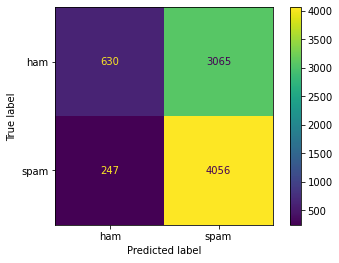

In [23]:
cm_rf = confusion_matrix(Y_test, rf_predictions)
cmd_rf = ConfusionMatrixDisplay(cm_rf, display_labels=['ham','spam'])
cmd_rf.plot();

### 5.1.4 RF ROC Curve

Random Forest: ROC AUC=0.705


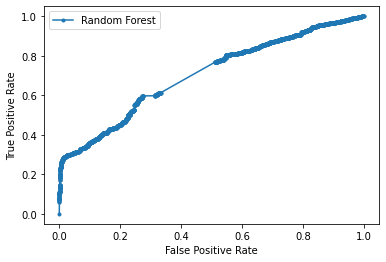

In [24]:
# predict probabilities
rf_probs = rf.predict_proba(X_test_fitted)

# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]
# calculate roc scores
rf_auc = roc_auc_score(Y_test, rf_probs)

# summarize scores
print('Random Forest: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
rf_fpr, rf_tpr, _ = roc_curve(Y_test, rf_probs)

# plot the roc curve for the model
plt.plot(rf_fpr, rf_tpr, marker='.', label = 'Random Forest')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

### 5.2 Naive Bayes

In [25]:
mbayes = MultinomialNB().fit(X_train_fitted, Y_train)

### 5.2.1 Store Naive Bayes via pickle

In [26]:
with open('../models3/mbayes_pkl', 'wb') as files:
    pickle.dump(mbayes, files)

In [27]:
with open('../models3/mbayes_pkl' , 'rb') as f:
    mbayes = pickle.load(f)

### 5.2.2 Use Naive Bayes for Ham/Spam Predictions

In [28]:
mbayes_predictions = mbayes.predict(X_test_fitted)
print(classification_report(Y_test, mbayes_predictions))
print(confusion_matrix(Y_test, mbayes_predictions))

              precision    recall  f1-score   support

           0       0.70      0.48      0.57      3695
           1       0.65      0.82      0.73      4303

    accuracy                           0.67      7998
   macro avg       0.68      0.65      0.65      7998
weighted avg       0.67      0.67      0.66      7998

[[1790 1905]
 [ 756 3547]]


### 5.2.3 Naive Bayes Confusion Matrix

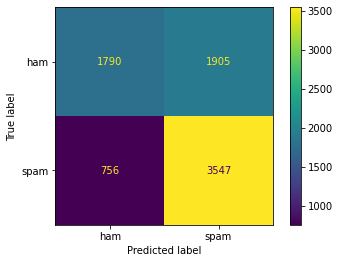

In [29]:
cm_mbayes = confusion_matrix(Y_test, mbayes_predictions)
cmd_mbayes = ConfusionMatrixDisplay(cm_mbayes, display_labels=['ham','spam'])
cmd_mbayes.plot();

### 5.2.4 Naive Bayes ROC Curve

Naive Bayes: ROC AUC=0.790


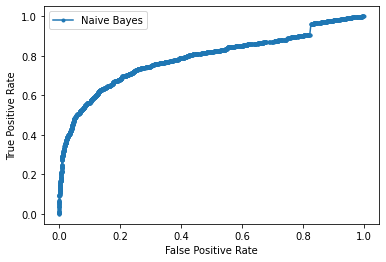

In [30]:
# predict probabilities
mbayes_probs = mbayes.predict_proba(X_test_fitted)

# keep probabilities for the positive outcome only
mbayes_probs = mbayes_probs[:, 1]
# calculate roc scores
mbayes_auc = roc_auc_score(Y_test, mbayes_probs)

# summarize scores
print('Naive Bayes: ROC AUC=%.3f' % (mbayes_auc))

# calculate roc curves
mbayes_fpr, mbayes_tpr, _ = roc_curve(Y_test, mbayes_probs)

# plot the roc curve for the model
plt.plot(mbayes_fpr, mbayes_tpr, marker='.', label = 'Naive Bayes')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

### 5.3 Logistic Regression

In [31]:
lr = LogisticRegression().fit(X_train_fitted, Y_train)

### 5.3.1 Store Logistic Regression via pickle

In [32]:
with open('../models3/lr_pkl', 'wb') as files:
    pickle.dump(lr, files)

In [33]:
with open('../models3/lr_pkl' , 'rb') as f:
    lr = pickle.load(f)

### 5.3.2 Use Logistic Regression for Ham/Spam Predictions

In [34]:
lr_predictions = lr.predict(X_test_fitted)
print(classification_report(Y_test, lr_predictions))
print(confusion_matrix(Y_test, lr_predictions))

              precision    recall  f1-score   support

           0       0.65      0.77      0.71      3695
           1       0.76      0.65      0.70      4303

    accuracy                           0.70      7998
   macro avg       0.71      0.71      0.70      7998
weighted avg       0.71      0.70      0.70      7998

[[2836  859]
 [1509 2794]]


### 5.3.3 Logistic Regression Confusion Matrix

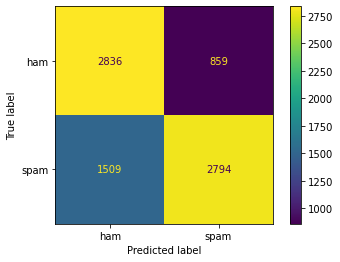

In [35]:
cm_lr = confusion_matrix(Y_test, lr_predictions)
cmd_lr = ConfusionMatrixDisplay(cm_lr, display_labels=['ham','spam'])
cmd_lr.plot();

### 5.3.4 Logistic Regression ROC Curve

Logistic Regression: ROC AUC=0.787


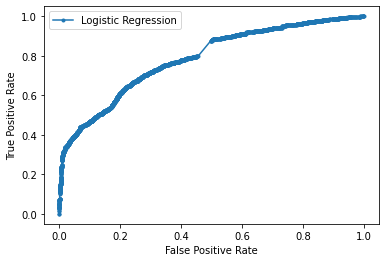

In [36]:
# predict probabilities
lr_probs = lr.predict_proba(X_test_fitted)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate roc scores
lr_auc = roc_auc_score(Y_test, lr_probs)

# summarize scores
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)

# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label = 'Logistic Regression')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

### 5.4 SVM

In [37]:
svm_SVC = svm.SVC(kernel = 'rbf', gamma = 0.01, probability = True).fit(X_train_fitted, Y_train)

### 5.4.1 Store SVM via pickle

In [38]:
with open('../models3/svm_pkl', 'wb') as files:
    pickle.dump(svm_SVC, files)

In [39]:
with open('../models3/svm_pkl' , 'rb') as f:
    svm_SVC = pickle.load(f)

### 5.4.2 Use SVM for Ham/Spam Predictions

In [40]:
svm_SVC_predictions = svm_SVC.predict(X_test_fitted)
print(classification_report(Y_test, svm_SVC_predictions))
print(confusion_matrix(Y_test, svm_SVC_predictions))

              precision    recall  f1-score   support

           0       0.46      1.00      0.63      3695
           1       1.00      0.01      0.02      4303

    accuracy                           0.47      7998
   macro avg       0.73      0.51      0.33      7998
weighted avg       0.75      0.47      0.31      7998

[[3695    0]
 [4252   51]]


### 5.4.3 SVM Confusion Matrix

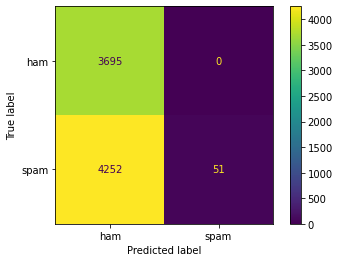

In [41]:
cm_svm = confusion_matrix(Y_test, svm_SVC_predictions)
cmd_svm = ConfusionMatrixDisplay(cm_svm, display_labels=['ham','spam'])
cmd_svm.plot();

### 5.4.4 SVM ROC Curve

SVM: ROC AUC=0.784


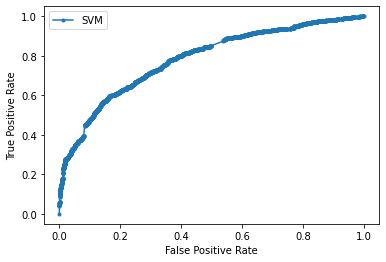

In [42]:
# predict probabilities
# https://www.discoverbits.in/371/sklearn-attributeerror-predict_proba-available-probability
svm_probs = svm_SVC.predict_proba(X_test_fitted)

# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]

# calculate roc scores
svm_auc = roc_auc_score(Y_test, svm_probs)

# summarize scores
print('SVM: ROC AUC=%.3f' % (svm_auc))

# calculate roc curves
svm_fpr, svm_tpr, _ = roc_curve(Y_test, svm_probs)

# plot the roc curve for the model
plt.plot(svm_fpr, svm_tpr, marker='.', label = 'SVM')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

### 5.5 KNN

In [43]:
knn = KNeighborsClassifier(n_neighbors = 5).fit(X_train_fitted, Y_train)

### 5.5.1 Store KNN via pickle

In [44]:
with open('../models3/knn_pkl', 'wb') as files:
    pickle.dump(knn, files)

In [45]:
with open('../models3/knn_pkl' , 'rb') as f:
    knn = pickle.load(f)

### 5.5.2 Use KNN for Ham/Spam Predictions

In [46]:
knn_predictions = knn.predict(X_test_fitted)
print(confusion_matrix(Y_test, knn_predictions))
print(classification_report(Y_test, knn_predictions))

[[ 559 3136]
 [ 617 3686]]
              precision    recall  f1-score   support

           0       0.48      0.15      0.23      3695
           1       0.54      0.86      0.66      4303

    accuracy                           0.53      7998
   macro avg       0.51      0.50      0.45      7998
weighted avg       0.51      0.53      0.46      7998



### 5.5.3 KNN Confusion Matrix

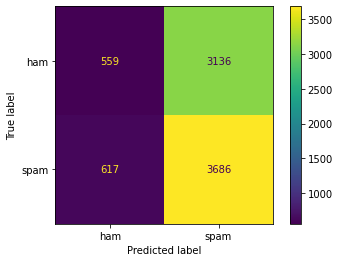

In [47]:
cm_knn = confusion_matrix(Y_test, knn_predictions)
cmd_knn = ConfusionMatrixDisplay(cm_knn, display_labels=['ham','spam'])
cmd_knn.plot();

### 5.5.4 KNN ROC Curve¶

KNN: ROC AUC=0.487


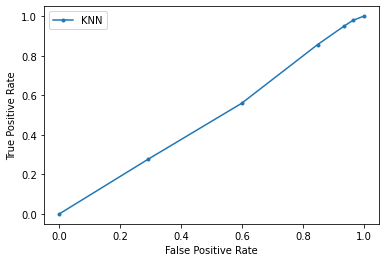

In [48]:
# https://www.discoverbits.in/371/sklearn-attributeerror-predict_proba-available-probability
knn_probs = knn.predict_proba(X_test_fitted)

# keep probabilities for the positive outcome only
knn_probs = knn_probs[:, 1]

# calculate roc scores
knn_auc = roc_auc_score(Y_test, knn_probs)

# summarize scores
print('KNN: ROC AUC=%.3f' % (knn_auc))

# calculate roc curves
knn_fpr, knn_tpr, _ = roc_curve(Y_test, knn_probs)

# plot the roc curve for the model
plt.plot(knn_fpr, knn_tpr, marker='.', label = 'KNN')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()